<a href="https://colab.research.google.com/github/fadindashafira/TIAToolBox/blob/main/01_wsi_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WSI Reading using TIATOOLBOX

Goal: This demo reads a whole slide image (WSI) using tiatoolbox.

Steps:
* We load a sample WSI
* Gather some key information
* Extract some image patches.

We will demonstrate TIATOOLBOX modules
`wsireader` [details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/wsicore/wsireader.py) and
`slide_info` [details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/wsicore/slide_info.py).



## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if:

1) you are not using the Colab plaform or

2) you are using Colab and this is not your first run of the notebook in the current runtime session.

If you nevertheless run the cell, you may get an error message, but no harm will be done.

On Colab the cell **installs** `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored.

Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [3]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1

print("Installation is done.")

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-_dwa6rs5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.31.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.4 which is incompatible.


Installation is done.


**IMPORTANT**: If you are using Colab and you run the cell above for the first time, please note that you need to restart the runtime before proceeding through (menu) *Runtime→Restart runtime*. This is needed to load the latest versions of prerequisite packages installed with TIATool. Having done this, you can do *Runtime→Run all* or *Runtime→Run after* or run the remaining cells one by one.



### Removing leftovers from previous runs

The cell below removes the directory `tmp` if it exists—a previous run may have created it. This cell can be skipped if you are running this notebook for the first time.



In [1]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )

### Set Up Plotting

Here we import `matplotlib` and set some options for plotting results to make the output look nice.



In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 150  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
plt.rcParams.update({"font.size": 5})

## Reading in a WSI

We **load** a small WSI, specified with the help of the **data module.** Here we include a function to **download a small sample SVS image** from our server.

This function then **returns the path to the downloaded file** which is stored in your system's temporary directory, e.g. `/tmp` on UNIX-like systems.



In [3]:
from tiatoolbox.data import small_svs

file_path = small_svs()
print(file_path)

/tmp/CMU-1-Small-Region.svs


Our code **shields** the user from the **incompatible formats** produced by **different models of scanners** from different vendors.

The function `WSIReader.open` has as input a particular WSI, with a particular image format, and outputs an object `reader`, whose base class is `WSIReader`, and whose derived class depends on the image format ([see details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/wsicore/wsireader.py)).

The reader `reader` provides important information about the WSI. Member functions obtain pixel- or patch-level information, using format-independent code, as we illustrate below.



In [16]:
from tiatoolbox.wsicore.wsireader import WSIReader

wsi = WSIReader.open(file_path) # Accept input path to WSI
print(wsi)

First, let's check the basic WSI metadata information, such as magnification, dimension, etc.
(`mpp` = microns per pixel).



In [17]:
# Pretty print for nice dictionary printing
from pprint import pprint

info_dict = wsi.info.as_dict()
pprint(info_dict)

{'axes': 'YXS',
 'file_path': PosixPath('/tmp/CMU-1-Small-Region.svs'),
 'level_count': 1,
 'level_dimensions': ((2220, 2967),),
 'level_downsamples': [1.0],
 'mpp': (0.499, 0.499),
 'objective_power': 20.0,
 'slide_dimensions': (2220, 2967),
 'vendor': 'aperio'}


### Thumbnail

To see a thumbnail of the WSI, we use the `slide_thumbnail` method of `reader`.


We load the thumbnail at $\times1.25$ (by default) objective power as follows:



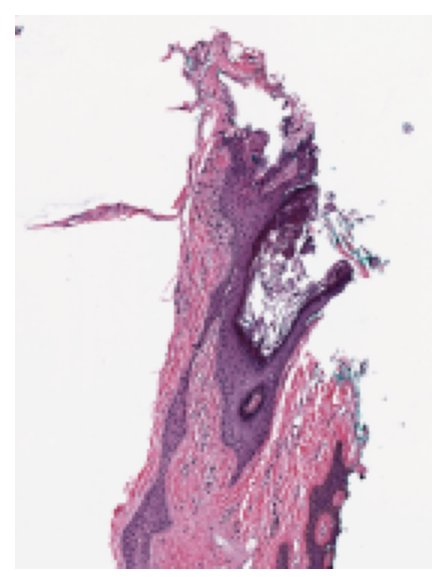

In [18]:
thumbnail = wsi.slide_thumbnail(resolution=1.25, units="power") # Read the WSI image thumbnail
plt.imshow(thumbnail)
plt.axis("off")
plt.show()

## Reading WSI regions

### i) Read Rect

`read_rect` = Read a region of the WSI image at a location and size.

Location = In terms of the baseline image (level 0 / maximum resolution)
Size = The output image size


We can read a region of the whole slide image at a given location and size using the `read_rect` method. Location can be stated as (x, y) tuple giving the top left pixel in the baseline (level 0) reference frame, and size as (width, height) tuple giving the desired output image size.

Reads can be performed at different resolutions by supplying a pair of arguments for the `resolution` and the `units` of resolution. `resolution` can be given as integer or float or tuple(float), default = 0.

Either a single number or a sequence of two numbers for x and y as tuple are valid. This value is in terms of the corresponding units. For example: resolution=0.5 and units=''mpp'' will read the slide at 0.5 microns per-pixel, and resolution=3, units=''level'' will read at level at pyramid level / resolution layer 3.

Supported units are: microns per pixel (''mpp''), objective power (''power''), pyramid / resolution level (''level''), pixels per baseline pixel (''baseline''), default =''level''.

 MPP value is not usually something you can see directly in the image, it's a measure of the resolution of the image, telling you how much real-world space each pixel represents.


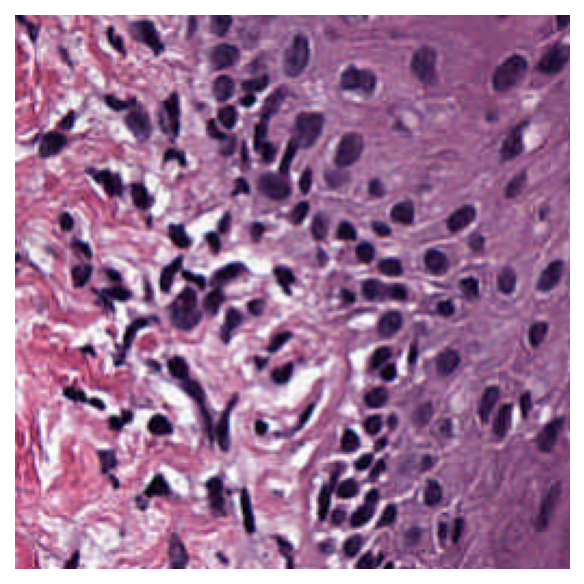

In [37]:
# Location coordinates in (x,y)
location = (1000, 1000)

# Size of the region in (width, height)
size = (256, 256)

# read the region using wsi reader's read rect at 0.5 mpp
img = wsi.read_rect(
    location,
    size,
    resolution=0.5,
    units="mpp",
)

plt.imshow(img)
plt.axis("off")
plt.show()

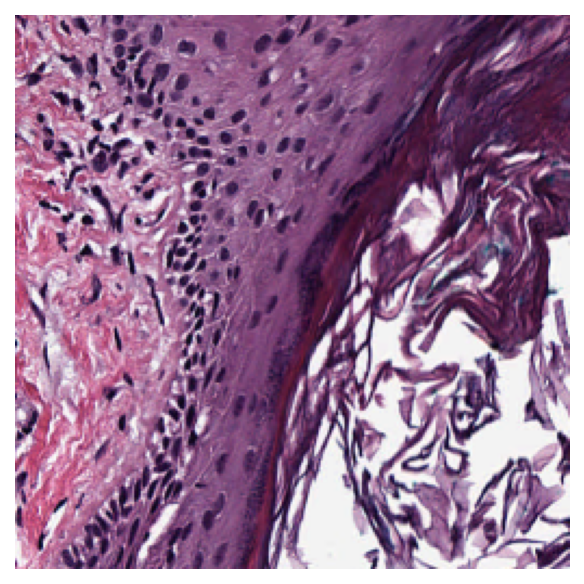

In [39]:
# Location coordinates in (x,y)
location = (1000, 1000)

# Size of the region in (width, height)
size = (256, 256)

# read the region using wsi reader's read rect at 0.5 mpp
img = wsi.read_rect(
    location,
    size,
    resolution=1.0,
    units="mpp",
)

plt.imshow(img)
plt.axis("off")
plt.show()


Note: The field of view varies with resolution when using read_rect().

![](https://tia-toolbox.readthedocs.io/en/latest/_images/read_rect_tissue.png)

As the location is in the baseline reference frame but the size (width and height) is the output image size, the field of view therefore changes as resolution changes.

If the WSI does not have a resolution layer corresponding exactly to the requested resolution (shown above in white with a dashed outline), a larger resolution is downscaled to achieve the correct requested output resolution.

If the requested resolution is higher than the baseline (maximum resultion of the image), then bicubic interpolation is applied to the output image.

![](https://tia-toolbox.readthedocs.io/en/latest/_images/read_rect-interpolated-reads.png)

When reading between the levels stored in the WSI, the coordinates of the requested region are projected to the next highest resolution. This resolution is then decoded and downsampled to produce the desired output. This is a major source of variability in the time take to perform a read operation. Reads which require reading a large region before downsampling will be significantly slower than reading at a fixed level.

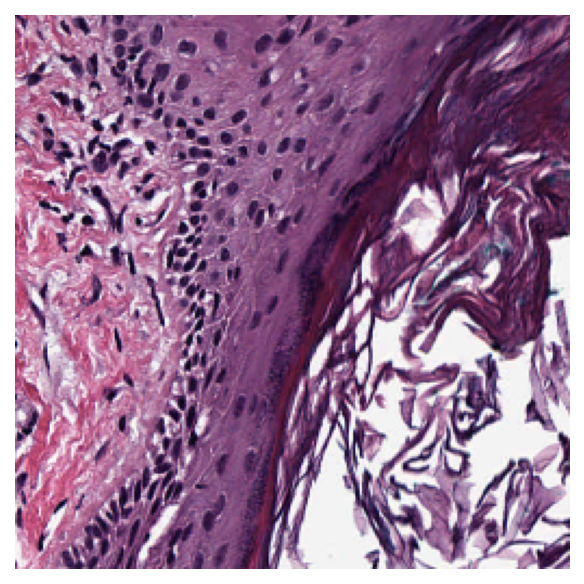

In [20]:
# E.g. Read a region at an objective power of 10x

location = (1000, 1000)
size = (256,256)

img = wsi.read_rect(
    location,
    size,
    resolution = 10,
    units = "power"
)

plt.imshow(img)
plt.axis("off")
plt.show()

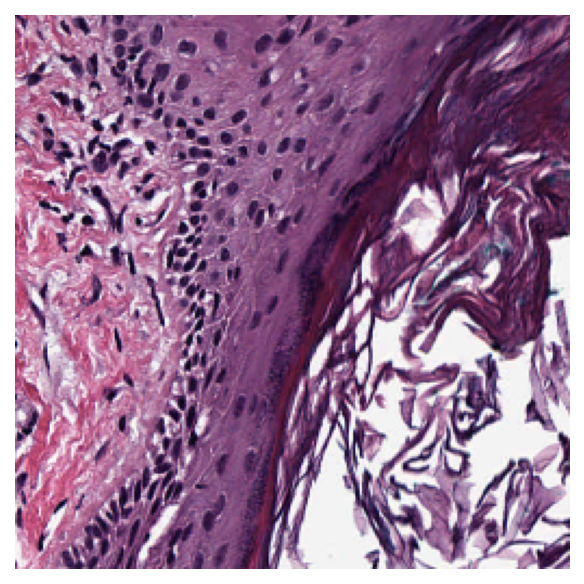

In [21]:
# Read a region at half of the full / baseline resolution
img = wsi.read_rect(
    location,
    size,
    resolution=0.5,
    units="baseline",
)

plt.imshow(img)
plt.axis("off")
plt.show()

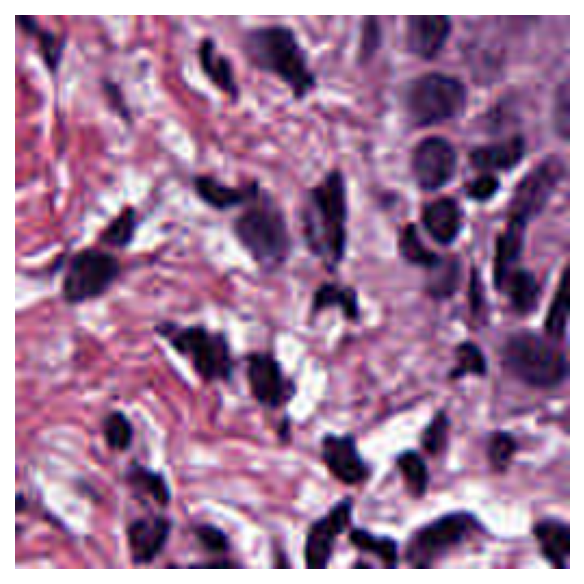

In [22]:
# Assuming the image has a native mpp of 0.5,
# interpolation will be applied here.
img = wsi.read_rect(
    location,
    size,
    resolution=0.25,
    units="mpp",
)

plt.imshow(img)
plt.axis("off")
plt.show()

### ii) Read bounds

Read a region of the whole slide image within given bounds.

Bounds are in terms of the baseline image (level 0 / maximum resolution).

Bounds is a tuple of (start_x, start_y, end_x, end_y) i.e., (left, top, right, bottom) of the region in baseline reference frame. However, with coord_space=''resolution'', the bound is expected to be at the requested `resolution` system.

Reads can be performed at different resolutions by supplying a pair of arguments for the resolution and the units of resolution.

Resolution can be given as integer or float or tuple(float), default = 0. Either a single number or a sequence of two numbers for x and y as tuple are valid. This value is in terms of the corresponding units. For example: resolution=0.5 and units=''mpp'' will read the slide at 0.5 microns per-pixel, and resolution=3, units=''level'' will read at level at pyramid level / resolution layer 3. Supported units are: microns per pixel (''mpp''), objective power (''power''), pyramid / resolution level (''level''), pixels per baseline pixel (''baseline''), default =''level''.

coord_space = ''baseline'' by default, this is a flag to indicate if the input bounds is in the baseline coordinate system (''baseline'') or is in the requested resolution system (''resolution'').



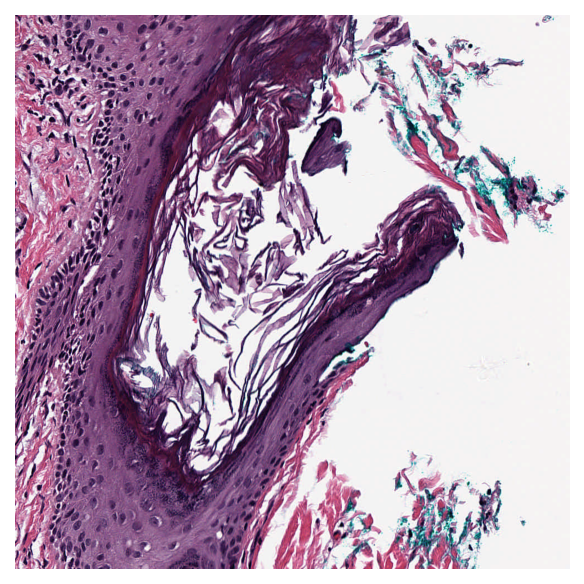

In [25]:
# Specify the bounds in terms of rectangle (left, top, right, bottom)
bounds = [1000, 1000, 2000, 2000]

# Read the region using wsi reader's read bounds at level 0
img = wsi.read_bounds(bounds, resolution=0, units="level")

plt.imshow(img)
plt.axis("off")
plt.show()

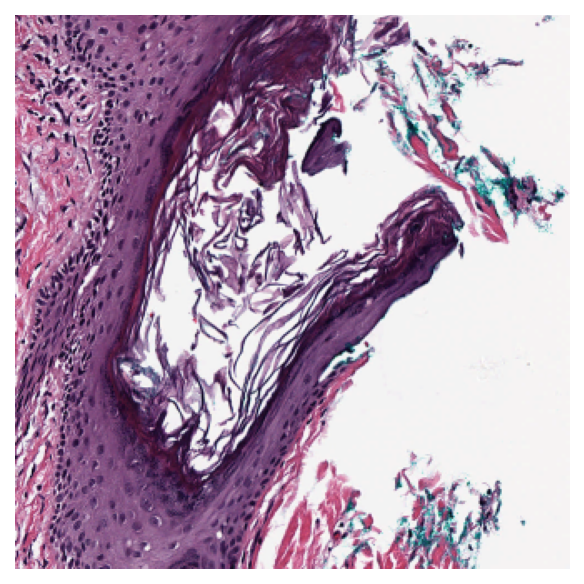

In [32]:
# Specify the bounds in terms of rectangle (left, top, right, bottom)
bounds = [1000, 1000, 2000, 2000]

# Read the region using wsi reader's read bounds at level 0
img = wsi.read_bounds(bounds, resolution=1.5, units="mpp")

plt.imshow(img)
plt.axis("off")
plt.show()

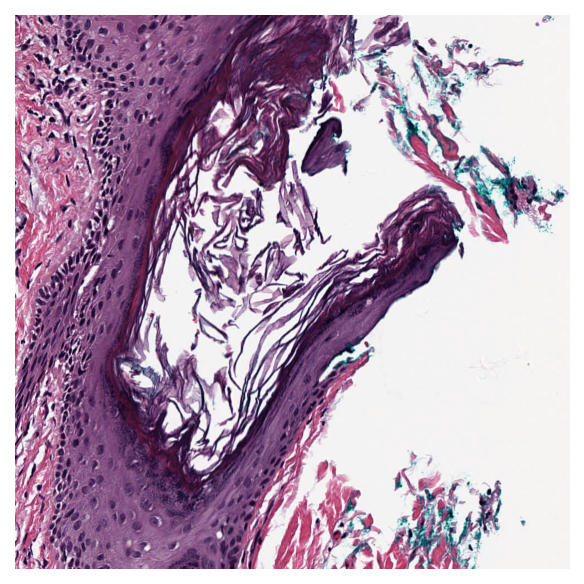

In [33]:
# Specify the bounds in terms of rectangle (left, top, right, bottom)
bounds = [1000, 1000, 2000, 2000]

# Read the region using wsi reader's read bounds at level 0
img = wsi.read_bounds(bounds, resolution=0.5, units="mpp")

plt.imshow(img)
plt.axis("off")
plt.show()

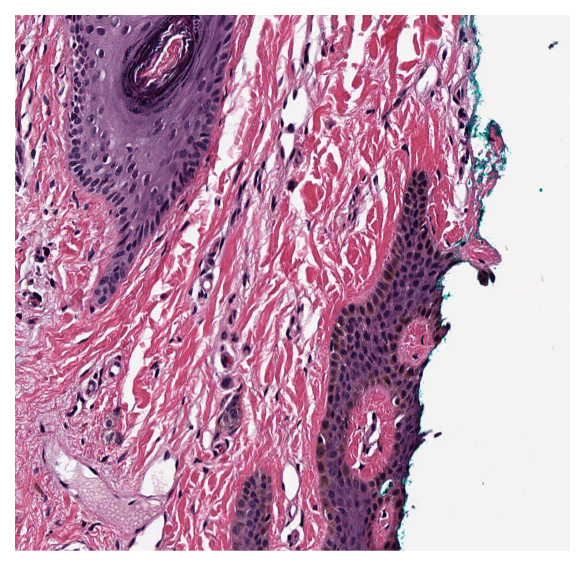

In [26]:
# Specify the bounds in terms of rectangle (left, top, right, bottom)
bounds = [1000, 2000, 2000, 3000]

# Read the region using wsi reader's read bounds at level 0
img = wsi.read_bounds(bounds, resolution=0, units="level")

plt.imshow(img)
plt.axis("off")
plt.show()

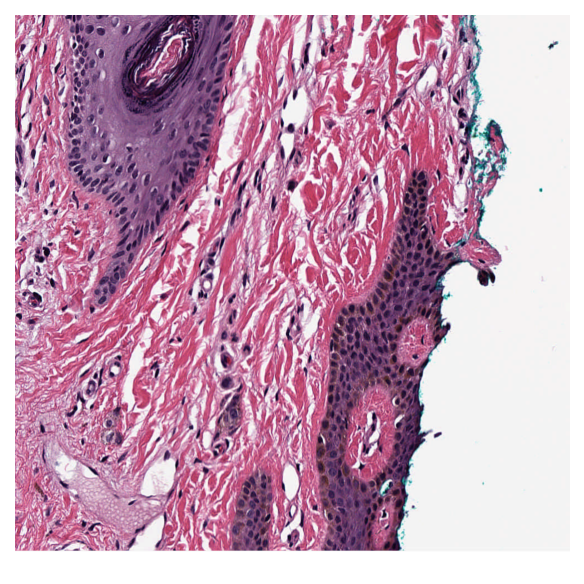

In [35]:
# Specify the bounds in terms of rectangle (left, top, right, bottom)
bounds = [1000, 2000, 2000, 3000]

# Read the region using wsi reader's read bounds at level 0
img = wsi.read_bounds(bounds, resolution=0.5, units="mpp")

plt.imshow(img)
plt.axis("off")
plt.show()

Note: The field of view remains the same as resolution is varied when using read_bounds().

![](https://tia-toolbox.readthedocs.io/en/latest/_images/read_bounds_tissue.png)

This is because the bounds are in the baseline (level 0) reference frame. Therefore, varying the resolution does not change what is visible within the output image.

If the WSI does not have a resolution layer corresponding exactly to the requested resolution (shown above in white with a dashed outline), a larger resolution is downscaled to achieve the correct requested output resolution.

If the requested resolution is higher than the baseline (maximum resultion of the image), then bicubic interpolation is applied to the output image.

## Tissue Masking

It is often useful to distinguish between tissue and glass (no tissue) in the image. For example, to avoid running computation expensive analysis for regions where is no tissue content. We compute a *mask*, by which we mean a **binary colouring of the pixels to either black=glass or white=tissue.** The white area is deliberately made a little larger than tissue area, as this will be appropriate for our task.

We provide a function `tissue_mask` on a `WSIReader` binarises the thumbnail on the basis of pixel intensity, using the Otsu method. Morphological operations improve the result.

Note that the `tissue_mask` function returns a `VirtualWSIReader` object rather than a NumPy array (although this can be accessed via the `.image` attribute). The returned `VirtualWSIReader` object also has some metadata copied from the original WSI.

This allows the lower resolution mask image to be read as it it were the full size WSI. This is particularly useful as it allows for using the same coordinates to read from the mask as from the original WSI.



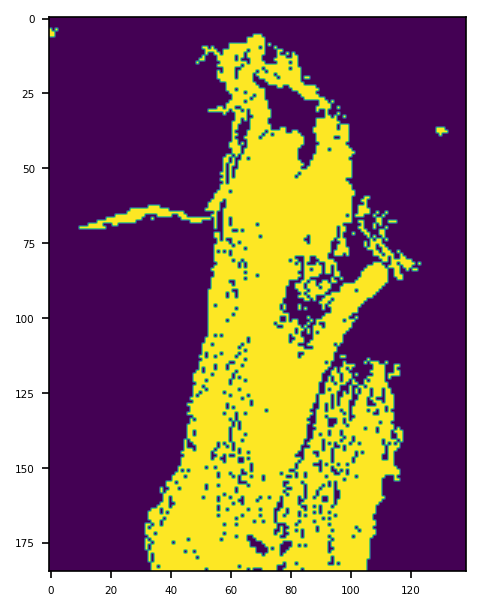

In [43]:
mask_reader = wsi.tissue_mask(resolution=4, units="mpp") # Create a tissue mask and wrap it in a VirtualWSIReader.
mask_thumbnail = mask_reader.slide_thumbnail(resolution=1.25, units="power")

plt.imshow(mask_thumbnail)
plt.show()

1. Otsu's Method:
Otsu's method is used to find the best threshold value to separate important objects from the background in an image. It looks for the value that makes the objects stand out the most, so we can easily tell them apart.

2. Morphological Methods:
Morphological methods are a set of tools that help change the shape and structure of objects in an image. They can make objects bigger or smaller, remove noise, or enhance certain features.

In simple terms, Otsu's method helps us separate important things from the background, while morphological methods help us change the shape and appearance of objects in an image.

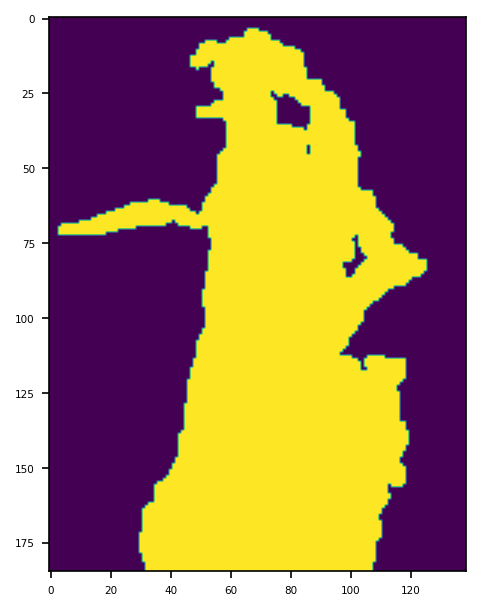

In [45]:
mask_reader_morph = wsi.tissue_mask("morphological", resolution=4, units="mpp")
mask_thumbnail_morph = mask_reader_morph.slide_thumbnail(resolution=1.25, units="power")

plt.imshow(mask_thumbnail_morph)
plt.show()

Here we show reading part of the tissue from `wsi` and also the corresponding part of the mask.



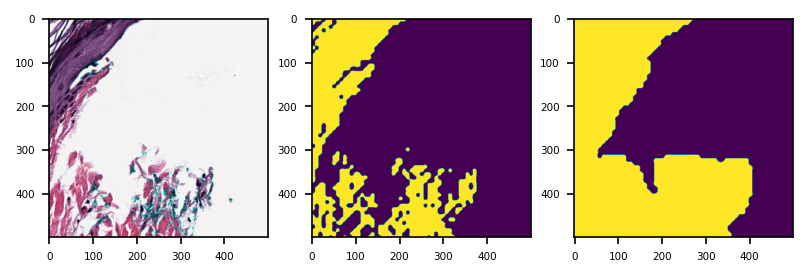

In [46]:
tissue_region = wsi.read_rect(
    location=(1500, 1500),
    size=(500, 500),
    resolution=0.5,
    units="mpp",
)
mask_region = mask_reader.read_rect(
    location=(1500, 1500),
    size=(500, 500),
    resolution=0.5,
    units="mpp",
)

mask_morph = mask_reader_morph.read_rect(
    location=(1500, 1500),
    size=(500, 500),
    resolution=0.5,
    units="mpp",
)
_, axs = plt.subplots(1, 3)
axs[0].imshow(tissue_region)
axs[1].imshow(mask_region, vmin=0, vmax=1)
axs[2].imshow(mask_morph, vmin=0, vmax=1)
plt.show()

Notice that the above two function calls to the two reader objects have identical arguments. This could also be written more concisely as follows:



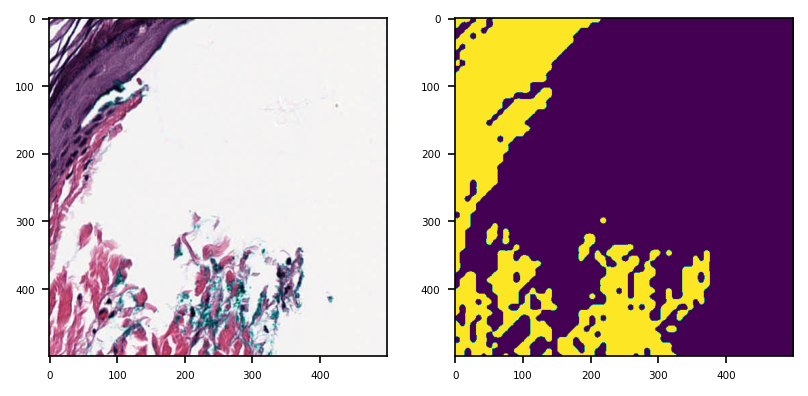

In [47]:
# Try modifying the parameters and see how the mask changes
location, size = (1500, 1500), (500, 500)
tissue_region, mask_region = (
    r.read_rect(location, size, 0.5, "mpp") for r in (wsi, mask_reader)
)
_, axs = plt.subplots(1, 2)
axs[0].imshow(tissue_region)
axs[1].imshow(mask_region, vmin=0, vmax=1)
plt.show()